In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Text-Classification

/content/drive/My Drive/Text-Classification


In [0]:
#!pip3 install underthesea

In [4]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from underthesea import word_tokenize
plt.switch_backend('agg')
%matplotlib inline

Using Theano backend.


In [0]:
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

In [6]:
# reading data
df = pd.read_excel('data/Data_class_question_40_class_new.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
num_classes = len(set(df['class']))
print('No. of unique classes',num_classes)

Shape of dataset  (705, 2)
Index(['Questions', 'class'], dtype='object')
No. of unique classes 40


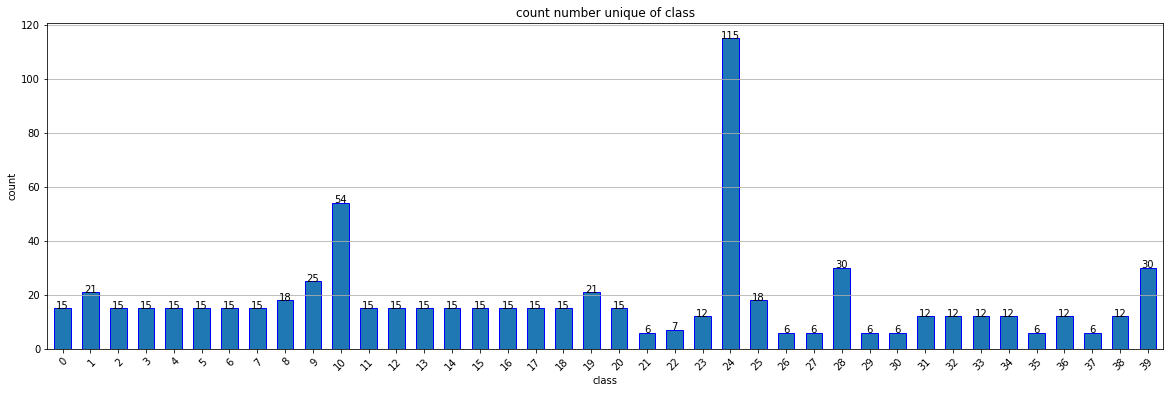

In [7]:
count_data = df['class'].value_counts().sort_index()
ax = count_data.plot(kind = 'bar', edgecolor='blue', width=0.6, figsize = (20,6))
# assign text on each bin of bar/histogram
for i, value in enumerate(count_data):
    ax.text(i, value, round(value, 1), horizontalalignment='center')

#ax.set_xticks(map(lambda x: x, range(0, len(count_data))))
ax.set_xticklabels(count_data.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('count number unique of class')
ax.set_xlabel('class')
ax.set_ylabel('count')
plt.show()

In [0]:
# test_class = [1,9,28,41]
# df_temp = pd.DataFrame([])
# for i, c in enumerate(test_class):
#   batch = df[df['class']==c]
#   batch.iloc[:,1] = i
#   df_temp = pd.concat([df_temp, batch], ignore_index = True)
#   print(batch.iloc[1,:])
# df = df_temp
# print(df.shape)

In [0]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [0]:
def clean_str(string):
    string = re.sub(r'[^\w\s]', '', string).lower()
    string = re.sub(r'\s+', ' ', string).strip()
    return string

In [0]:
def remove_stopwords(stop_words, string):
  string = string.join([' ']*2)
  for sw in stop_words:
    string = string.replace(sw.join([' ']*2), ' ')
    string = re.sub(r'\s+', ' ', string)
    if string[0] != ' ':
      string = ' ' + string
    if string[-1] != ' ':
      string = string + ' '
  return string.strip()

In [0]:
texts = []
labels = []

stop_words = open('/content/drive/My Drive/Text-Classification/vietnamese-stopwords.txt', mode = 'r', encoding = 'utf8')
stop_words = stop_words.readlines()
stop_words = [x.replace('\n', '') for x in stop_words]
stop_words += ['ạ']
stop_words.remove('tin')

for idx in range(df.Questions.shape[0]):
    text = df.Questions[idx]
    text = clean_str(text)
    # text = remove_stopwords(stop_words, text)
    texts.append(text)
    

for idx in df['class']:
    labels.append(idx)

In [13]:
print(len(texts))
texts[:10]

705


['mình là nữ mình có học công nghệ thông tin được không',
 'em là nữ em có thể theo học các ngành công nghệ thông tin không ạ',
 'em là nữ có khó khăn gì khi học ngành công nghệ thông tin không ạ',
 'mình là nữ ngành công nghệ thông tin có phù hợp với mình không ạ',
 'em là nữ ngành công nghệ thông tin có phù hợp với em không',
 'ngành công nghệ thông tin có phù hợp với nữ giới không ạ',
 'ngành này có phân biệt giới tính nữ không vậy',
 'nữ có nên học ngành công nghệ thông tin',
 'mấy bạn nam có kỳ thị nữ học công nghệ thông tin không vậy',
 'học công nghệ thông tin không giành cho nữ giới à']

In [14]:
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
def texts_to_sequences(text, word_index_list):
  sequences = []
  for q in text:
    temp = []
    for tokens in q:
      if tokens in word_index_list:
        temp.append(word_index_list.index(tokens)+1)
    sequences.append(temp)
  return sequences

In [17]:
# Recreate word_index and sequences to convenience with vietnamese vector words
word_index = set()
text_temps = []
for q in texts:
  word_tokens = word_tokenize(q)
  text_temps.append(word_tokens)
  for w in word_tokens:
    word_index.add(w)
word_index_list = list(word_index)

sequences = texts_to_sequences(text_temps, word_index_list)

word_index = {t.replace(' ', ''): i for i, t in enumerate(word_index)}
print(len(word_index))
print(len(sequences))
print(sequences[:100])
print(list(word_index.items())[:10])
print(sequences)

623
705
[[178, 250, 604, 178, 122, 181, 318, 115, 543], [218, 250, 604, 218, 600, 522, 181, 112, 147, 318, 543, 55], [218, 250, 604, 122, 519, 430, 68, 181, 147, 318, 543, 55], [178, 250, 604, 147, 318, 122, 460, 276, 178, 543, 55], [218, 250, 604, 147, 318, 122, 460, 276, 218, 543], [147, 318, 122, 460, 276, 437, 543, 55], [147, 529, 122, 507, 504, 604, 543, 473], [604, 122, 31, 181, 147, 318], [117, 326, 591, 122, 425, 181, 318, 543, 473], [181, 318, 543, 570, 391, 437, 419], [411, 178, 250, 591, 253, 465, 342, 117], [591, 465, 604, 430, 548, 181, 115, 147, 318, 149, 543], [181, 318, 396, 317, 340, 72, 419], [178, 250, 604, 240, 170, 68, 181, 132, 476, 51, 591], [604, 181, 318, 122, 554, 543], [476, 122, 511, 69, 543, 55], [476, 122, 18, 122, 511, 199, 69, 543, 55], [476, 122, 511, 199, 129, 69, 543, 55], [476, 122, 83, 129, 69, 543, 55], [511, 69, 122, 149, 250, 463, 83, 118, 476, 543, 55], [476, 122, 511, 69, 149, 543], [35, 218, 426, 405, 295, 191, 486, 321, 484, 199, 522, 281, 51

In [0]:
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)

# word_index = tokenizer.word_index
# print('Number of Unique Tokens',len(word_index))

In [19]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('data [0]: ', data[0])

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)
print('labels', labels[:4])

# shuffle the whole data and labels
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
print('indices ...%s...', str(indices[:10]))
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print('nb_validation_samples', nb_validation_samples)

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('shape x_train', x_train.shape)
print('shape y_train', y_train.shape)

data [0]:  [  0   0   0   0   0   0   0   0   0   0   0 178 250 604 178 122 181 318
 115 543]
Shape of Data Tensor: (705, 20)
Shape of Label Tensor: (705, 40)
labels [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
indices ...%s... [ 87 700 533  46 631 452  65 179 500 488]
nb_validation_samples 141
shape x_train (564, 20)
shape y_train (564, 40)


In [20]:
# embeddings_index = {}
# f = open('/content/drive/My Drive/Text-Classification/cc.vi.300.vec',encoding='utf8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
with open('embeddings_index_vi.pickle', 'rb') as handle:
    embeddings_index = pickle.load(handle)

print('Total %s word vectors in cc.vi.300d' % len(embeddings_index))
for i, couple in enumerate(embeddings_index.items()):
  print((i, str(couple)[:100]))
  if i==10: break

Total 2000000 word vectors in cc.vi.300d
(0, "('2000000', array([ 0.0481,  0.0338,  0.0062, -0.0755,  0.0543, -0.0391, -0.0876,\n        0.045 ,  0")
(1, "(',', array([-8.610e-02,  6.560e-02, -9.020e-02,  9.300e-03, -3.300e-02,\n       -4.000e-02, -1.083e-")
(2, '("\'", array([-1.5800e-02,  1.3080e-01, -2.5480e-01, -6.8100e-02,  6.9200e-02,\n        2.8600e-02,  6')
(3, "('.', array([-7.5600e-02,  1.5600e-02, -2.9870e-01, -4.1200e-02, -1.4600e-02,\n       -7.4500e-02,  4")
(4, "('</s>', array([-3.1900e-02, -2.3200e-02, -1.0290e-01, -4.7600e-02,  1.0100e-02,\n       -1.8070e-01,")
(5, "('-', array([-3.8700e-02,  6.2800e-02, -5.4940e-01, -1.0820e-01, -5.8000e-02,\n       -7.3900e-02,  1")
(6, "(':', array([ 1.910e-02, -2.170e-01, -3.163e-01, -2.800e-02, -1.190e-02,\n       -1.000e-01,  1.283e-")
(7, "('và', array([-9.5800e-02,  6.7000e-02,  3.1000e-02, -2.1200e-02,  4.8500e-02,\n       -1.1160e-01,  ")
(8, "('là', array([-4.2000e-03,  5.7700e-02,  1.2540e-01, -9.2000e-03,  6.9100e-02,\n 

In [21]:
'hochiminh' in embeddings_index

True

In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
# l_cov1= Conv1D(16, 3, activation='relu')(embedded_sequences)
# l_pool1 = MaxPooling1D(2)(l_cov1)
# l_cov2 = Conv1D(16, 3, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(2)(l_cov2)
# # l_cov3 = Conv1D(16, 5, activation='relu')(l_pool2)
# # l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
# l_flat = Flatten()(l_pool2)
# l_dense = Dense(16, activation='relu')(l_flat)
# l_dense2 = Dense(16, activation='relu')(l_dense)
# preds = Dense(len(macronum), activation='softmax')(l_dense2)
num_filters = 32
filter_sizes = [3,4,5]
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedded_sequences)
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=40, activation='softmax')(dropout)

model = Model(sequence_input, output)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      187200      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 20, 300, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 18, 1, 32)    28832       reshape_1[0][0]                  
____________________________________________________

In [0]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=40, batch_size=2,callbacks=[cp])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [0]:
text = "em không biết chọn ngành nào để học"
text = clean_str(str(text))
# text = remove_stopwords(stop_words, text)
text = word_tokenize(text)
print(text)
sequence = texts_to_sequences([text], word_index_list)
print(sequence)
text = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
print(word_index_list)

trường có ưu tiên có xét tuyển học bạ không ạ [0]

bài thi đánh giá năng lực thi như thế nào ạ [1]

em muốn đăng kí học phần mềm nhưng không biết [2]

khối thi xét tuyển đại học tại trường [3]

In [0]:
result = model.predict(text)[0]
print("reponse belong to class: %s"%np.where(result == result.max()))
print(result)

In [0]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [0]:
# from PIL import Image
# display(Image.open('cnn_model.png'))